In [1]:
from jaxevocomm.models import ActorRNN, ScannedRNN

import jax
import jax.numpy as jnp

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from reproducible_figures import (
    set_plotting_style, save_reproducible_figure
)

In [2]:
n_zs = 5

actor_rnn = ActorRNN(n_zs, {})

ac_init_x = (
    jnp.zeros((1, 1, n_zs)),
    jnp.zeros((1, 1)),
)
rng = jax.random.PRNGKey(0)
ac_init_hstate = ScannedRNN.initialize_carry(1, 128)
actor_network_params = actor_rnn.init(rng,
                                      ac_init_hstate,
                                      ac_init_x)
_, act_init_dist = actor_rnn.apply(actor_network_params,
                                   ac_init_hstate,
                                   ac_init_x)
act_init_dist.sample(seed=0)

I0000 00:00:1713106867.283156 2518563 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Array([[3]], dtype=int32)

In [3]:
@jax.jit
def already_trained_listener(z, params, rng):
    if isinstance(z, int):
        z = jnp.array([z])
    ac_in = (
        jax.nn.one_hot(z, n_zs).reshape((1, z.shape[0], n_zs)),
        jnp.zeros((1, z.shape[0])),
    )
    ac_init_hstate = ScannedRNN.initialize_carry(z.shape[0], 128)
    _, act_dist = actor_rnn.apply(params, ac_init_hstate, ac_in)
    guesses = act_dist.sample(seed=rng) == z
    return guesses.mean()


@jax.jit
def both_untrained(z, params, rng):
    if isinstance(z, int):
        z = jnp.array([z])

    ac_in = (
        jax.nn.one_hot(z, n_zs).reshape((1, z.shape[0], n_zs)),
        jnp.zeros((1, z.shape[0])),
    )
    ac_init_hstate = ScannedRNN.initialize_carry(z.shape[0], 128)
    _, act_dist = actor_rnn.apply(params, ac_init_hstate, ac_in)

    rng, _rng = jax.random.split(rng)
    next_z = act_dist.sample(seed=_rng).squeeze()

    ac_in = (
        jax.nn.one_hot(next_z, n_zs).reshape((1, z.shape[0], n_zs)),
        jnp.zeros((1, z.shape[0])),
    )
    _, act_dist = actor_rnn.apply(params, ac_init_hstate, ac_in)
    guesses = act_dist.sample(seed=rng) == z
    return guesses.mean()

In [4]:
from evosax.core import ParameterReshaper
from evosax import SimpleGA

params_reshaper = ParameterReshaper(actor_network_params, n_devices=1)
popsize = 100
strategy = SimpleGA(popsize=popsize, num_dims=params_reshaper.total_params)
evo_state = strategy.initialize(rng, strategy.default_params)
population, evo_state = strategy.ask(rng, evo_state, strategy.default_params)

ParameterReshaper: 116741 parameters detected for optimization.


In [131]:
outer_trials = 10000
inner_trials = 10


def compute_eu(utility_fn, rng, params):
    rng, _rng = jax.random.split(rng)
    zs = jax.random.randint(_rng, (inner_trials,), 0, n_zs)
    params = params_reshaper.reshape_single(params)
    return utility_fn(zs, params, rng)


from functools import partial

@jax.jit
def run_outer_trial(seed):
    rng = jax.random.PRNGKey(seed)
    compute_already_trained_eu = jax.jit(partial(compute_eu, 
                                                 already_trained_listener,
                                                 rng))
    already_trained_eus = jax.vmap(compute_already_trained_eu)(population)

    compute_both_untrained_eu = jax.jit(partial(compute_eu,
                                                both_untrained,
                                                rng))

    both_untrained_eus = jax.vmap(compute_both_untrained_eu)(population)

    return already_trained_eus, both_untrained_eus

seeds = np.arange(outer_trials)
already_trained_eus, both_untrained_eus = jax.vmap(run_outer_trial)(seeds)

In [136]:
already_trained_eus.shape

(10000, 100)

In [94]:



@jax.jit
def compute_eu_double_random_fn(seed):
    rng = jax.random.PRNGKey(seed)
    rng, _rng = jax.random.split(rng)
    zs = jax.random.randint(_rng, (inner_trials,), 0, n_zs)
    return double_random_fn(zs, rng)


eu2 = jax.vmap(compute_eu_double_random_fn)(seeds)
eu2.mean(), eu2.var()

(Array(0.20058, dtype=float32), Array(0.01577567, dtype=float32))

In [87]:
n_envs = 1
obs_dim = 16
n_signals = obs_dim
n_non_signal_acts = obs_dim
act_dim = n_non_signal_acts + n_signals

actor_rnn = ActorRNN(act_dim, {})

ac_init_x = (
    jnp.zeros((1, n_envs, obs_dim)),
    jnp.zeros((1, n_envs)),
)
_rng = jax.random.PRNGKey(0)
ac_init_hstate = ScannedRNN.initialize_carry(n_envs, 128)
actor_network_params = actor_rnn.init(_rng,
                                      ac_init_hstate,
                                      ac_init_x)

In [67]:
from evosax.core import ParameterReshaper
from evosax import SimpleGA

params_reshaper = ParameterReshaper(actor_network_params, n_devices=1)
popsize = 100
strategy = SimpleGA(popsize=popsize, num_dims=params_reshaper.total_params)
evo_state = strategy.initialize(_rng, strategy.default_params)

population, evo_state = strategy.ask(_rng, evo_state, strategy.default_params)

ParameterReshaper: 119568 parameters detected for optimization.


In [69]:
dists = []

for z in range(obs_dim):
    for i in range(popsize):
        params = params_reshaper.reshape_single(population[i])

        ac_in = (
            jax.nn.one_hot(z, act_dim).reshape((1, n_envs, obs_dim)),
            jnp.zeros((1, n_envs)),
        )
        _, act_dist = actor_rnn.apply(params, ac_init_hstate, ac_in)

        dists.extend([
            {'msg': m, 'prob': float(p), 'z': z}
            for m, p in enumerate(act_dist.probs.squeeze())
        ])

df = pd.DataFrame(dists)

In [176]:
import scipy.stats as stats

x = np.array(df.msg == df.z)
stats.bootstrap((x,), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=0.0596484375, high=0.0655859375), bootstrap_distribution=array([0.06132812, 0.06277344, 0.06175781, ..., 0.06074219, 0.06136719,
       0.06335937]), standard_error=0.0015083429615104303)

Text(6.944444444444445, 0.5, '$P(\\pi^s_\\theta(m | z) = p)$, for $\\theta \\sim U(P)$')

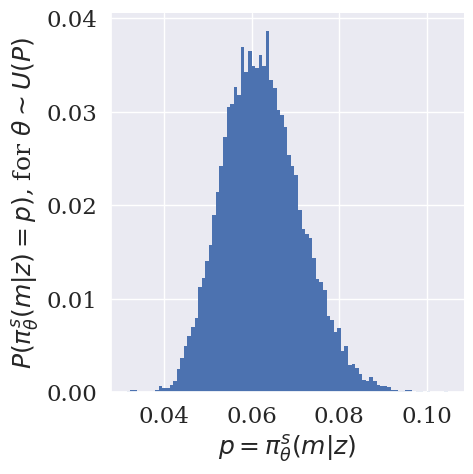

In [99]:
set_plotting_style()
grid = sns.displot(df, x='prob', stat='probability', linewidth=0, alpha=1.0)
ax = grid.axes[0, 0]
ax.set_xlabel(r'$p = \pi^s_\theta(m | z)$')
ax.set_ylabel(r'$P(\pi^s_\theta(m | z) = p)$, for $\theta \sim U(P)$')

<Axes: xlabel='msg', ylabel='prob'>

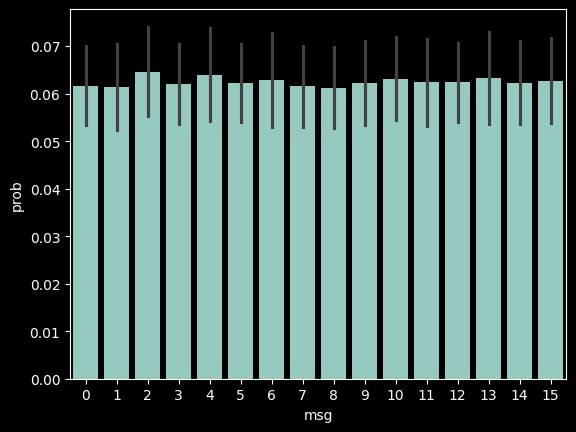

In [72]:
sns.barplot(df, x='msg', y='prob', errorbar='sd')

In [107]:
int(act_dist.sample(seed=2).squeeze())

9

In [177]:
listener_dists = []

samples = 500
import random


for seed in range(samples):
    z = random.randint(0, obs_dim - 1)
    i = random.randint(0, popsize - 1)

    params = params_reshaper.reshape_single(population[i])

    ac_in = (
        jax.nn.one_hot(z, obs_dim).reshape((1, n_envs, obs_dim)),
        jnp.zeros((1, n_envs)),
    )
    _, msg_dist = actor_rnn.apply(params, ac_init_hstate, ac_in)

    msg = msg_dist.sample(seed=seed).squeeze()

    ac_in = (
        jax.nn.one_hot(msg, act_dim).reshape((1, n_envs, act_dim)),
        jnp.zeros((1, n_envs)),
    )
    _, act_dist = actor_rnn.apply(params, ac_init_hstate, ac_in)

    listener_dists.extend([
        {
            'pop_i': i,
            'msg': int(msg),
            'prob': float(p),
            'z': z,
            'seed': seed,
            'act': a
        }
        for a, p in enumerate(act_dist.probs.squeeze())
    ])

listener_df = pd.DataFrame(listener_dists)

Text(21.444444444444443, 0.5, '$P(\\pi^l_\\theta(m | z) = p)$, for $\\theta \\sim U(P)$')

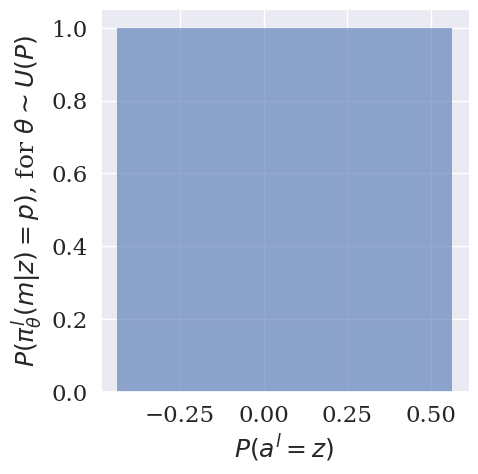

In [182]:
listener_df['ans_correct'] = listener_df.z == listener_df.act
ans_correct_dist = listener_df.groupby('pop_i').ans_correct.mean().reset_index()


set_plotting_style()
grid = sns.displot(
    ans_correct_dist,
    x='ans_correct', stat='probability',
    linewidth=0, alpha=0.6
)
ax = grid.axes[0, 0]
ax.set_xlabel(r'$P(a^l = z)$')
ax.set_ylabel(r'$P(\pi^l_\theta(m | z) = p)$, for $\theta \sim U(P)$')

In [161]:
np.mean(listener_df.z == listener_df.act)

0.0625

Text(6.944444444444445, 0.5, '$P(\\pi^l_\\theta(m | z) = p)$, for $\\theta \\sim U(P)$')

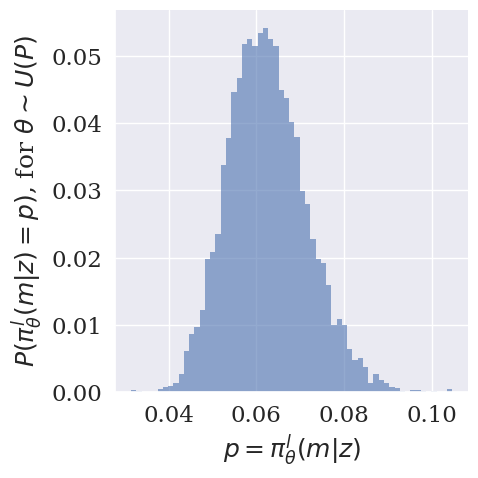

In [120]:
set_plotting_style()
grid = sns.displot(
    listener_df,
    x='prob', stat='probability',
    linewidth=0, alpha=0.6
)
ax = grid.axes[0, 0]
ax.set_xlabel(r'$p = \pi^l_\theta(m | z)$')
ax.set_ylabel(r'$P(\pi^l_\theta(m | z) = p)$, for $\theta \sim U(P)$')

In [116]:
speaker_df = df
speaker_df['Agent'] = 'Speaker'
listener_df['Agent'] = 'Listener'

In [123]:
listener_df.shape, speaker_df.shape

((8000, 6), (25600, 4))

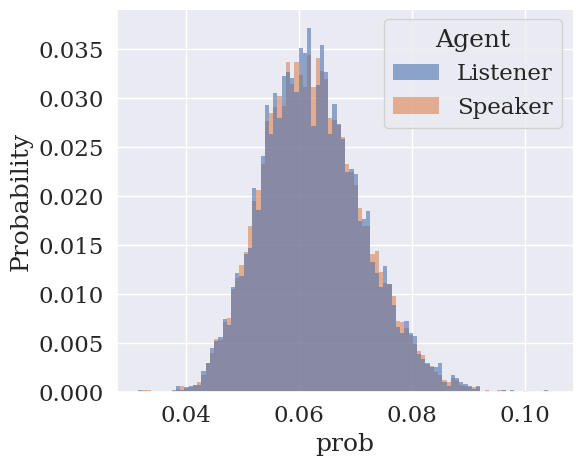

In [157]:
set_plotting_style()
g = sns.displot(
    pd.concat([listener_df, speaker_df]),
    x='prob', stat='probability', hue='Agent',
    common_norm=False,
    linewidth=0, alpha=0.6,
    aspect=1.25
)
sns.move_legend(obj=g, loc='upper right',
                bbox_to_anchor=(0.735, 0.95),
                frameon=True)

plt.show()

In [11]:
_, msg_dist = actor_rnn.apply(actor_network_params, ac_init_hstate, ac_init_x)
msg_dist.probs.squeeze()

Array([0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625],      dtype=float32)

In [50]:
dists = []
for m in range(act_dim):
    ac_in = (
        jax.nn.one_hot(m, act_dim).reshape((1, n_envs, obs_dim)),
        jnp.zeros((1, n_envs)),
    )
    _, act_dist = actor_rnn.apply(actor_network_params, ac_init_hstate, ac_in)
    dists.extend([
        {'msg': m, 'prob': float(p), 'act': a}
        for a, p in enumerate(act_dist.probs.squeeze())
    ])

df = pd.DataFrame(dists)

In [56]:

# df.groupby('act')['prob'].aggregate(np.std)

/tmp/ipykernel_3787607/3613760585.py:2: FutureWarning: The provided callable <function std at 0x7fc1e457ae80> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df.groupby('act')['prob'].aggregate(np.std)


act
0     0.000026
1     0.000015
2     0.000024
3     0.000028
4     0.000026
5     0.000033
6     0.000023
7     0.000031
8     0.000027
9     0.000026
10    0.000022
11    0.000019
12    0.000029
13    0.000027
14    0.000032
15    0.000021
Name: prob, dtype: float64

<Axes: xlabel='act', ylabel='prob'>

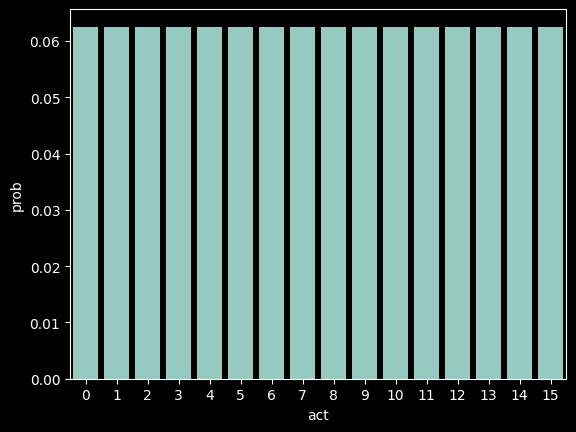

In [53]:
import seaborn as sns


sns.barplot(df, x='act', y='prob', errorbar='sd')